Import required modules

In [1]:
import pylab as plt
%matplotlib inline


import numpy as np
import xidplus
from xidplus import moc_routines
output_folder='./'

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Load up posteriors output from XID+

In [12]:
priors,posterior=xidplus.load('test_stan_order_9.pkl')
priors,posterior_numpyro=xidplus.load('test_numpyro_order_9.pkl')

### Posterior replicated data
We can use each sample we have from the posterior, and use it to make a replicated map, including simulating the instrumental noise, and the estimated confusion noise. You can think of these maps as all the possible maps that are allowed by the data. 

> NOTE: You will require the `FFmpeg` library installed to run the movie

In [14]:
xidplus.replicated_map_movie(priors,posterior,50)

In [15]:
xidplus.replicated_map_movie(priors,posterior_numpyro,50)

### Joint Posterior Analysis of sources

In [16]:
#Select source you want to plot joint distribution
s1=2
s2=18

In [17]:
posterior.samples['src_f'].shape,posterior_numpyro.samples['src_f'].shape

((2000, 3, 607), (2000, 3, 607))

Sources 2 and 18 are close together, lets look at their joint posterior probabiity distribution. The code below is an example of how you can plot the joint posterior probability density function for the  250𝜇m  flux, and an inset of the real map.

INFO: Auto-setting vmin to -1.672e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.614e+01 [aplpy.core]


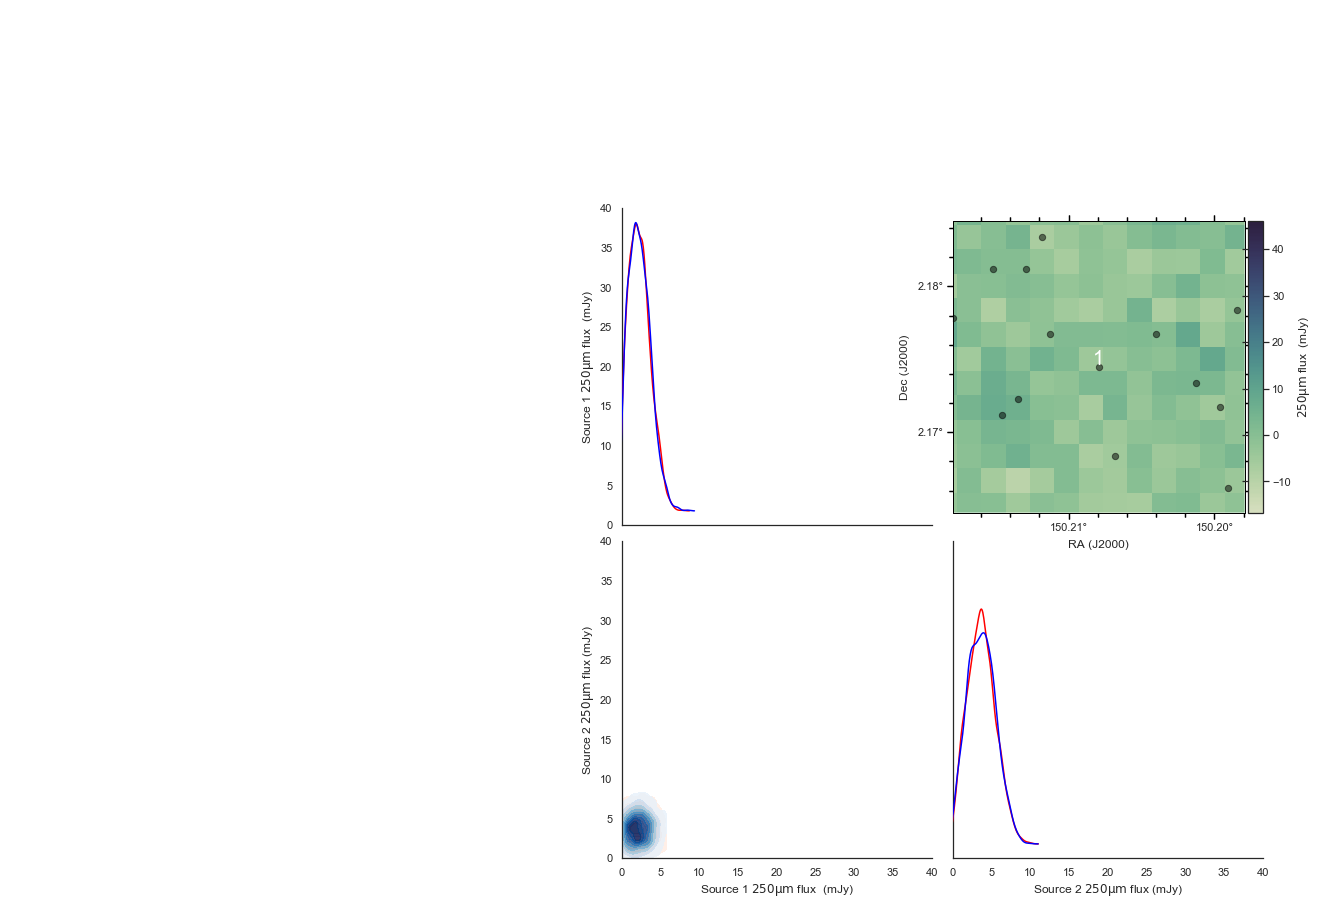

In [18]:
import aplpy
import seaborn as sns
sns.set(color_codes=True)
import pandas as pd
sns.set_style("white")
from xidplus import posterior_maps as postmaps



labels=[r'Source 1 $250\mathrm{\mu m}$ flux  (mJy)',r'Source 2 $250\mathrm{\mu m}$ flux (mJy)']
df = pd.DataFrame(posterior.samples['src_f'][:,0,[s1,s2]],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

g.data=pd.DataFrame(posterior_numpyro.samples['src_f'][:,0,[s1,s2]],columns=labels)
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.set(ylim=(0,40))
g.set(xlim=(0,40))


g.axes[0,1].spines['bottom'].set_color('white')
g.axes[0,1].spines['left'].set_color('white')
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

real_250 = aplpy.FITSFigure(postmaps.make_fits_image(priors[0],priors[0].sim)[1],figure=g.fig,subplot=(2,2,2))
real_250.show_colorscale(cmap=cmap)

real_250.show_markers(priors[0].sra, priors[0].sdec, edgecolor='black', facecolor='black',
                marker='o', s=40, alpha=0.5)
real_250.recenter(priors[0].sra[s1], priors[0].sdec[s1], radius=0.01)

real_250.add_label(priors[0].sra[s1], priors[0].sdec[s1]+0.0005, 1, relative=False,size=20,color='white')
real_250.add_label(priors[0].sra[s2], priors[0].sdec[s2]-0.0010, 2, relative=False,size=20,color='white')
real_250.tick_labels.set_xformat('dd.dd')
real_250.tick_labels.set_yformat('dd.dd')


real_250.add_colorbar(axis_label_text=r'$250\mathrm{\mu m}$ flux  (mJy)')  

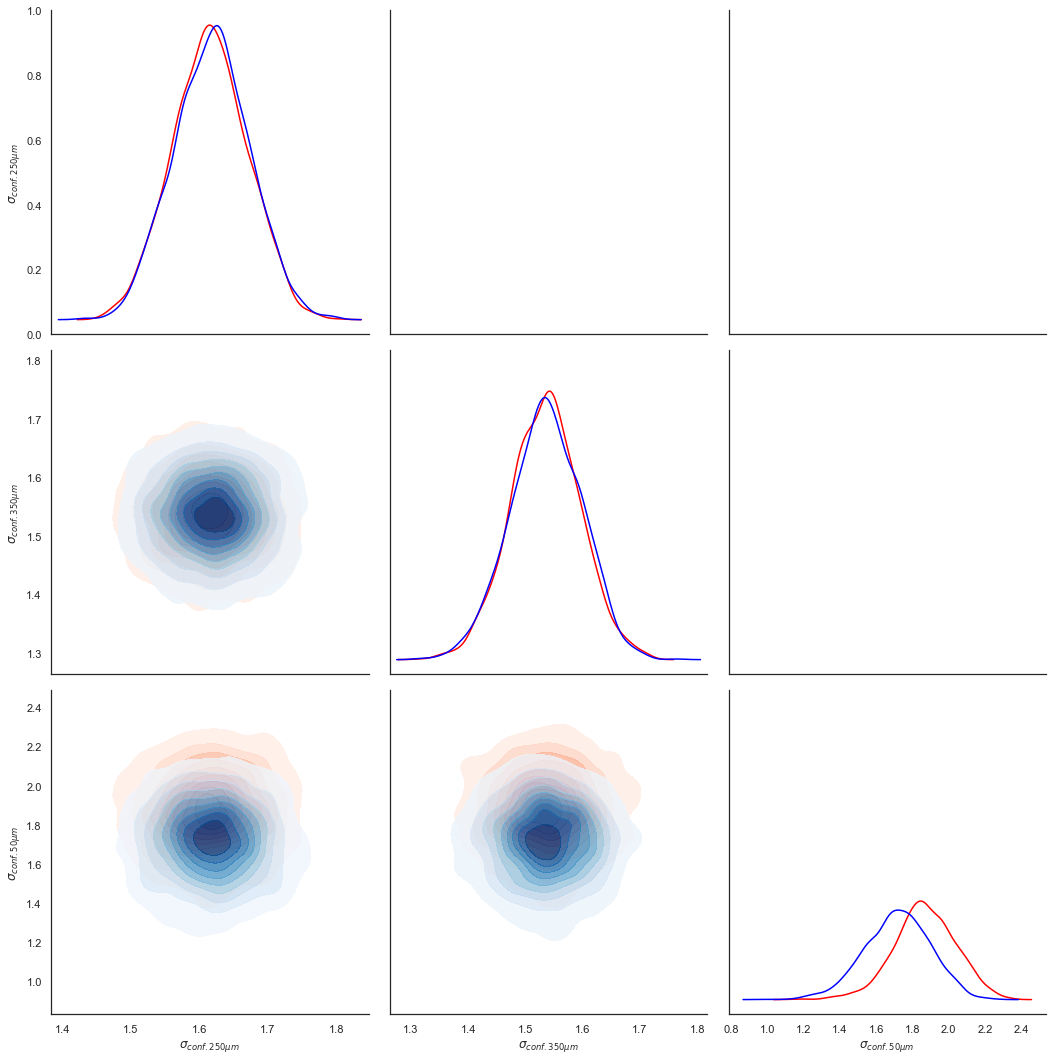

In [10]:
labels=[r'$\sigma_{conf. %d \mu m}$' %(b) for b in [250,350,50]]
df = pd.DataFrame(posterior.samples['sigma_conf'],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.data=pd.DataFrame(posterior_numpyro.samples['sigma_conf'],columns=labels)
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)

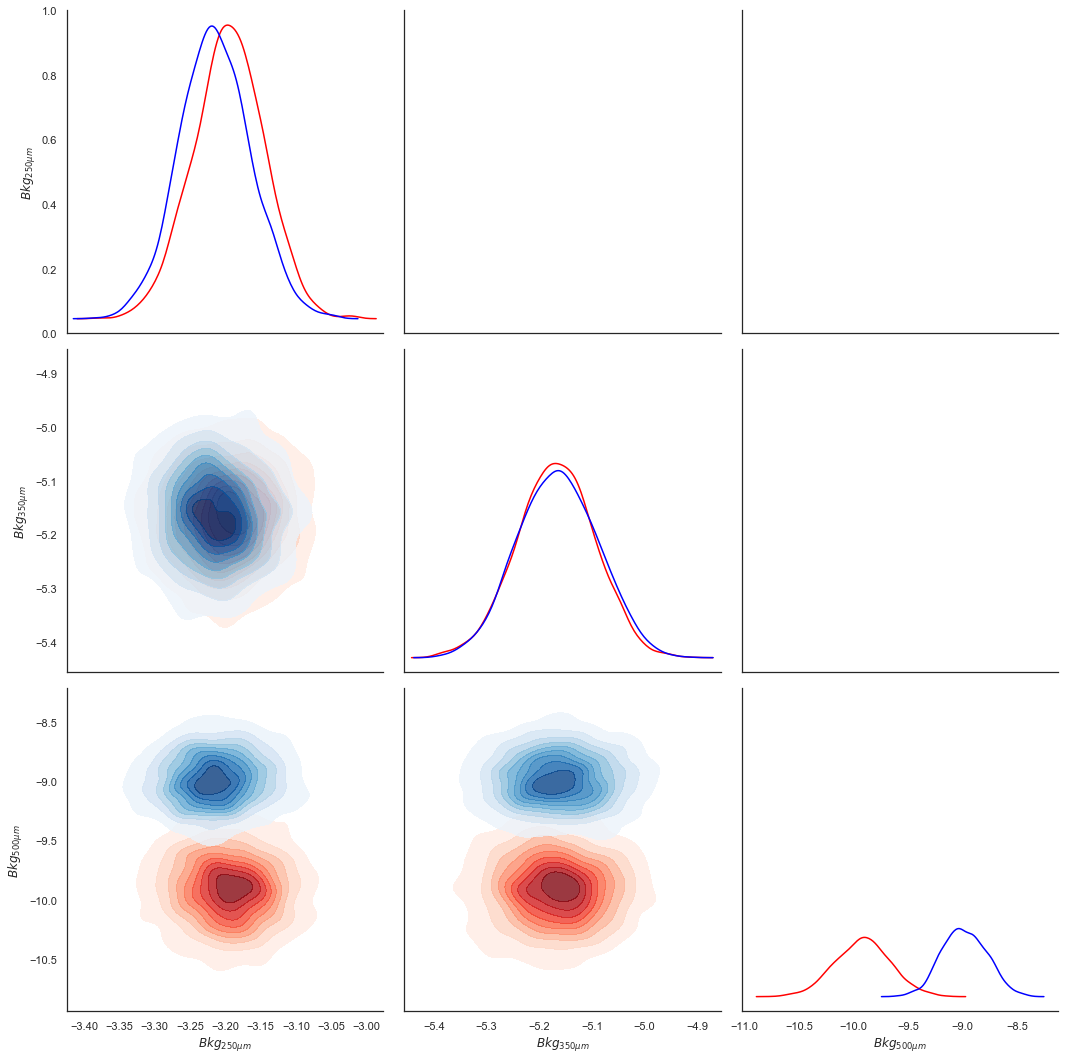

In [21]:
labels=[r'$Bkg_{%d \mu m}$' %(b) for b in [250,350,500]]
df = pd.DataFrame(posterior.samples['bkg'],columns=labels)
g = sns.PairGrid(df,size=5)
g.map_diag(sns.kdeplot,c='Red')
g.map_lower(sns.kdeplot, cmap="Reds",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)
g.data=pd.DataFrame(posterior_numpyro.samples['bkg'],columns=labels)
g.map_diag(sns.kdeplot,c='Blue')
g.map_lower(sns.kdeplot, cmap="Blues",alpha=0.8,n_levels=10,normed=True, shade=True,shade_lowest=False)


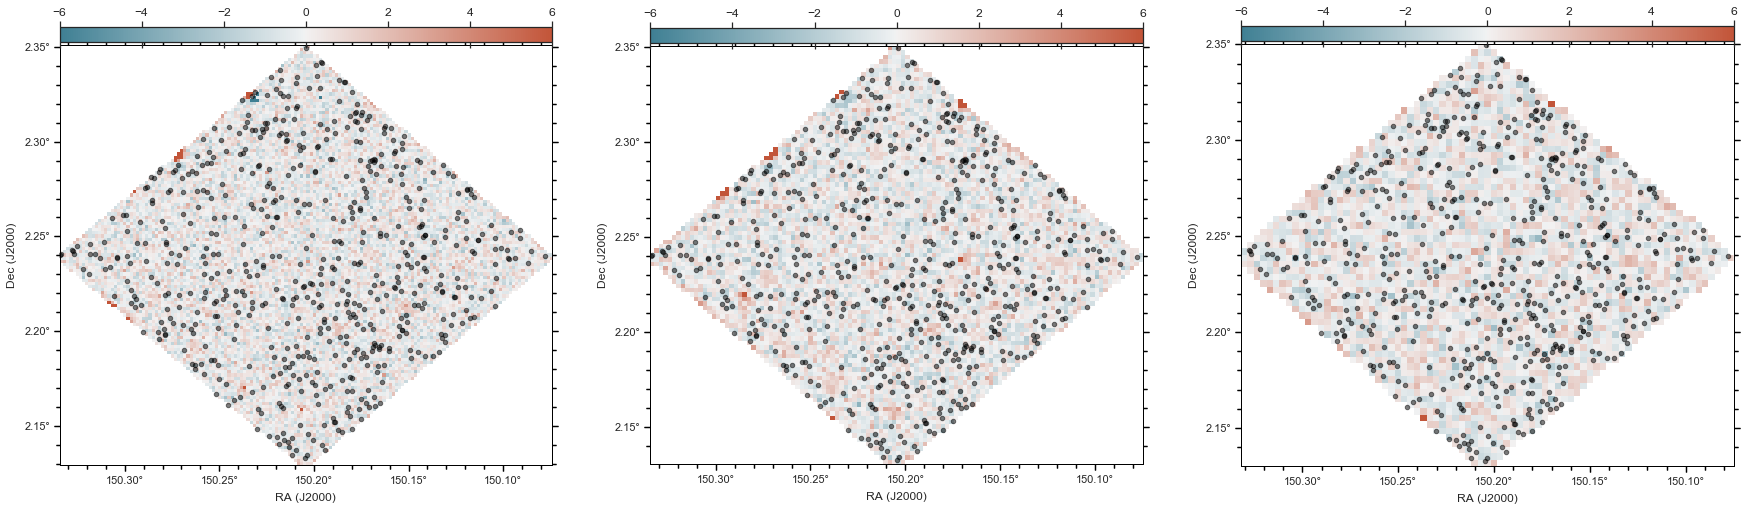

In [22]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

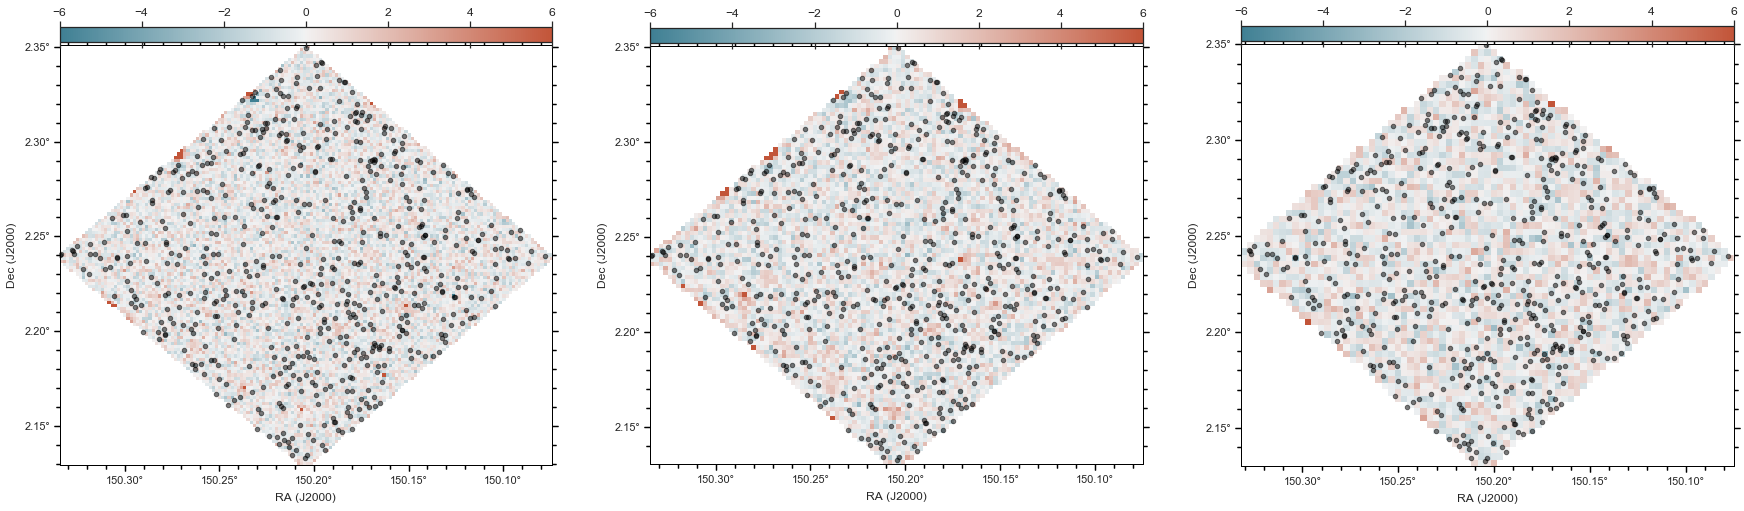

In [23]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior_numpyro)

### Flux comparisons

In [24]:
#Folder containing prior input catalogue
catfolder=xidplus.__path__[0]+'/../test_files/'
#prior catalogue
prior_cat='lacey_07012015_MillGas.ALLVOLS_cat_PSW_COSMOS_test.fits'

In [25]:
from astropy.io import ascii, fits
hdulist = fits.open(catfolder+prior_cat)
fcat=hdulist[1].data
hdulist.close()
inra=fcat['RA']
indec=fcat['DEC']
# select only sources with 100micron flux greater than 50 microJy
sgood=fcat['S100']>0.050
inra=inra[sgood]
indec=indec[sgood]

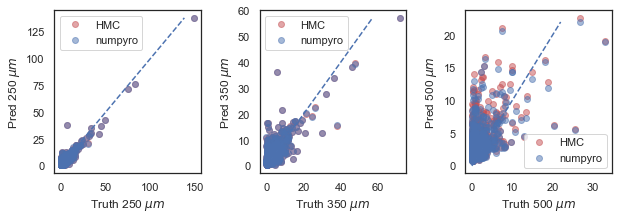

In [26]:
fig,axes=plt.subplots(1,3,figsize=(10,3))
band=[250,350,500]
for i in range(0,3):
    axes[i].plot(fcat['S%d' %band[i]][sgood][priors[0].ID-1],np.mean(posterior.samples['src_f'],axis=0)[i,:],'ro',label='HMC',alpha=0.5)
    #axes[i].plot(fcat['S%d' %band[i]][sgood][priors[0].ID-1],np.mean(posterior_pyro.samples['src_f'],axis=0)[i,:],'go',label='VB',alpha=0.5)
    axes[i].plot(fcat['S%d' %band[i]][sgood][priors[0].ID-1],np.mean(posterior_numpyro.samples['src_f'],axis=0)[i,:],'bo',label='numpyro',alpha=0.5)

    axes[i].plot(np.arange(0,np.max(np.mean(posterior.samples['src_f'],axis=0)[i,:])),np.arange(0,np.max(np.mean(posterior.samples['src_f'],axis=0)[i,:])),'b--')
    axes[i].set_xlabel('Truth %d $\mu m$' % band[i])
    axes[i].set_ylabel('Pred %d $\mu m$' % band[i])
    axes[i].legend()
plt.subplots_adjust(wspace=0.4)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


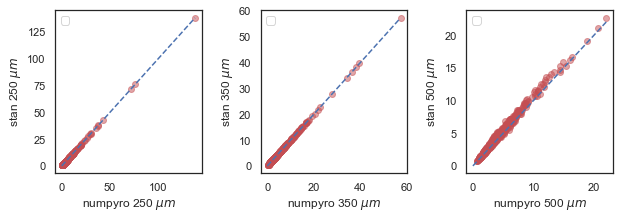

In [27]:
fig,axes=plt.subplots(1,3,figsize=(10,3))
band=[250,350,500]
for i in range(0,3):
    axes[i].plot(np.mean(posterior_numpyro.samples['src_f'],axis=0)[i,:],np.mean(posterior.samples['src_f'],axis=0)[i,:],'ro',alpha=0.5)
    
    axes[i].plot(np.arange(0,np.max(np.mean(posterior.samples['src_f'],axis=0)[i,:])),np.arange(0,np.max(np.mean(posterior.samples['src_f'],axis=0)[i,:])),'b--')
    axes[i].set_xlabel('numpyro %d $\mu m$' % band[i])
    axes[i].set_ylabel('stan %d $\mu m$' % band[i])
    axes[i].legend()
plt.subplots_adjust(wspace=0.4)